In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


from crispr_millipede import encoding as cme
from crispr_millipede import modelling as cmm

import pandas as pd
import numpy as np

from Bio import SeqIO
from Bio.Seq import Seq

import matplotlib.pyplot as plt
import logomaker
import seaborn as sns
import matplotlib.patches as patches

In [2]:
amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"
print(f"Length of amplicon {len(amplicon)}")

Length of amplicon 346


In [3]:


design_matrix_spec = cmm.MillipedeDesignMatrixProcessingSpecification(
    wt_normalization=False,
    total_normalization=True,
    sigma_scale_normalized=True,
    decay_sigma_scale=True,
    K_enriched=5,
    K_baseline=5,
    a_parameter=0.0005,
    set_offset_as_presort = True,
    offset_normalized = False,
    offset_psuedocount = 1 # OTHERWISE will get infinity error when taking log(count +1) for offset, since 0 counts could be acceptable depending on thresholding
)

millipede_model_specification_set = {
    "joint_replicate_per_experiment_models" : cmm.MillipedeModelSpecification(
        model_types=[cmm.MillipedeModelType.NORMAL_SIGMA_SCALED, cmm.MillipedeModelType.NORMAL],
        replicate_merge_strategy=cmm.MillipedeReplicateMergeStrategy.COVARIATE,
        experiment_merge_strategy=cmm.MillipedeExperimentMergeStrategy.SEPARATE,
        S = 5,
        tau = 0.01,
        tau_intercept = 0.0001,
        cutoff_specification=cmm.MillipedeCutoffSpecification(
            per_replicate_each_condition_num_cutoff = 0, 
            per_replicate_all_condition_num_cutoff = 1, 
            all_replicate_num_cutoff = 0, 
            all_experiment_num_cutoff = 0,
            baseline_pop_all_condition_each_replicate_num_cutoff = 3,
            baseline_pop_all_condition_acceptable_rep_count = 2,
            enriched_pop_all_condition_each_replicate_num_cutoff = 3,
            enriched_pop_all_condition_acceptable_rep_count = 2,
            presort_pop_all_condition_each_replicate_num_cutoff = 3,
            presort_pop_all_condition_acceptable_rep_count = 2,
            
        ),
        design_matrix_processing_specification=design_matrix_spec
    )
}

In [4]:
paired_end_experiments_inputdata_denoised = cmm.MillipedeInputDataExperimentalGroup(
    data_directory="./", 
    enriched_pop_fn_experiment_list = ["20240807_v0_1_84_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    enriched_pop_df_reads_colname = "#Reads_CD19minus",
    baseline_pop_fn_experiment_list = ["20240807_v0_1_84_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    baseline_pop_df_reads_colname = "#Reads_CD19plus", 
    presort_pop_fn_experiment_list = ["20240807_v0_1_84_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    presort_pop_df_reads_colname = '#Reads_presort',
    experiment_labels = ["ABE8e"],
    reps = [0,1,2],
    millipede_model_specification_set = millipede_model_specification_set
   )


Performing initial input validation checks...
Passed validation.
Retrieving data for
	Replicate Merge Strategy: MillipedeReplicateMergeStrategy.COVARIATE 
	Experiment Merge Strategy MillipedeExperimentMergeStrategy.SEPARATE
	Cutoff: 
                    per_replicate_each_condition_num_cutoff=0, 
                    per_replicate_presort_condition_num_cutoff=0, 
                    per_replicate_all_condition_num_cutoff=1, 
                    all_replicate_num_cutoff=0, 
                    all_experiment_num_cutoff=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0,
                    enriched_pop_per_condition_each_replicate_num_cutoff=0,
                    enriched_pop_per_condition_acceptable_rep_count=0,
                    presort_pop_per_condition_each_replicate_num_cutoff=0,
                    presort_pop_per_

## Run QC Tests 

In [5]:
data = paired_end_experiments_inputdata_denoised.millipede_model_specification_set_with_data['joint_replicate_per_experiment_models'][1].data[0]
data1 = data[data['intercept_exp0_rep0'] == 1]
data2 = data[data['intercept_exp0_rep1'] == 1]
data3 = data[data['intercept_exp0_rep2'] == 1]

print(data)
print(data1)
print(data2)
print(data3)

      intercept_exp0_rep0  intercept_exp0_rep1  intercept_exp0_rep2  21T>C  \
0                     1.0                  0.0                  0.0      0   
1                     1.0                  0.0                  0.0      0   
2                     1.0                  0.0                  0.0      0   
3                     1.0                  0.0                  0.0      0   
4                     1.0                  0.0                  0.0      0   
...                   ...                  ...                  ...    ...   
3915                  0.0                  0.0                  1.0      1   
3916                  0.0                  0.0                  1.0      1   
3917                  0.0                  0.0                  1.0      1   
3918                  0.0                  0.0                  1.0      1   
3919                  0.0                  0.0                  1.0      1   

      23T>C  28A>G  31T>C  35T>C  36A>G  39T>C  ...  #Reads_CD1

In [40]:
merged_encodings_millipede_rep0_rep1 = pd.merge(left=data1, right=data2, how="outer", on=[col for col in data2.columns if ">" in col], suffixes=("_rep0", "_rep1"))
merged_encodings_millipede_rep0_rep2 = pd.merge(left=data1, right=data3, how="outer", on=[col for col in data2.columns if ">" in col], suffixes=("_rep0", "_rep2"))
merged_encodings_millipede_rep1_rep2 = pd.merge(left=data2, right=data3, how="outer", on=[col for col in data2.columns if ">" in col], suffixes=("_rep1", "_rep2"))


In [6]:
data.loc[3916, ['#Reads_CD19plus', '#Reads_CD19minus']]


#Reads_CD19plus     0.000006
#Reads_CD19minus    0.000078
Name: 3916, dtype: float64

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/MilliV2/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


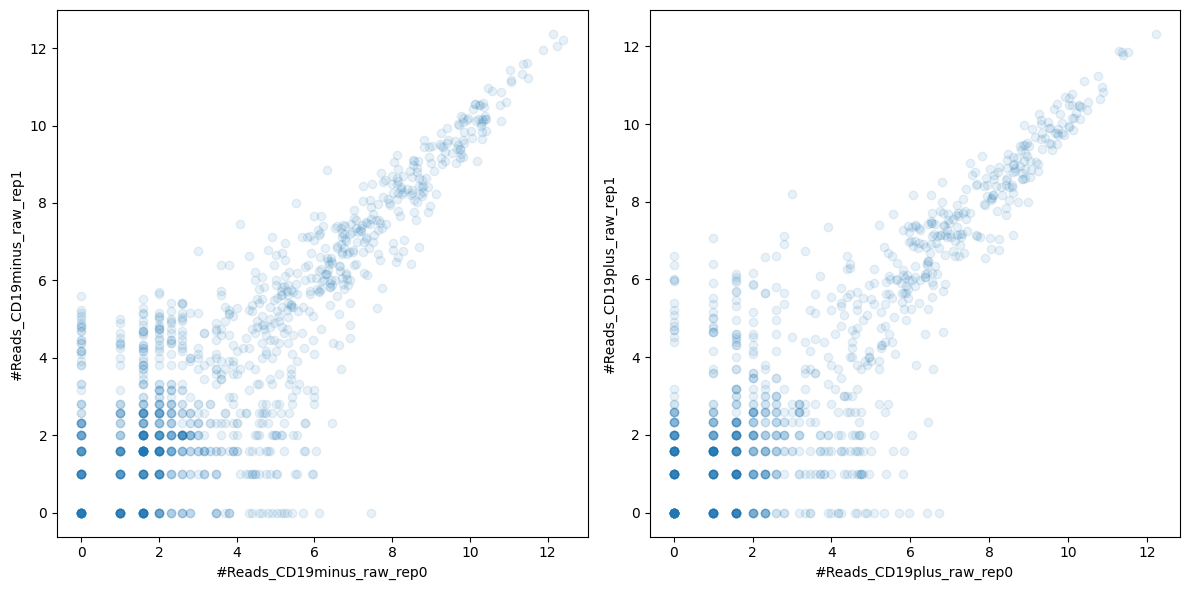

In [41]:
merged_encodings_millipede_rep0_rep1_minus_plus = merged_encodings_millipede_rep0_rep1[['#Reads_CD19minus_raw_rep0', '#Reads_CD19minus_raw_rep1', '#Reads_CD19plus_raw_rep0', '#Reads_CD19plus_raw_rep1',
                                                                                       '#Reads_CD19minus_rep0', '#Reads_CD19minus_rep1', '#Reads_CD19plus_rep0', '#Reads_CD19plus_rep1',
                                                                                       'score_rep0','score_rep1']]
merged_encodings_millipede_rep0_rep1_minus_plus = merged_encodings_millipede_rep0_rep1_minus_plus.dropna()
merged_encodings_millipede_rep0_rep1_minus_plus = merged_encodings_millipede_rep0_rep1_minus_plus.drop(merged_encodings_millipede_rep0_rep1_minus_plus.index[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatter plot
ax1.scatter(np.log2(merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19minus_raw_rep0']),
            np.log2(merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19minus_raw_rep1']),
            alpha=0.1)
ax1.set_xlabel('#Reads_CD19minus_raw_rep0')
ax1.set_ylabel('#Reads_CD19minus_raw_rep1')

# Plot the second scatter plot
ax2.scatter(np.log2(merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19plus_raw_rep0']),
            np.log2(merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19plus_raw_rep1']),
            alpha=0.1)
ax2.set_xlabel('#Reads_CD19plus_raw_rep0')
ax2.set_ylabel('#Reads_CD19plus_raw_rep1')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/MilliV2/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


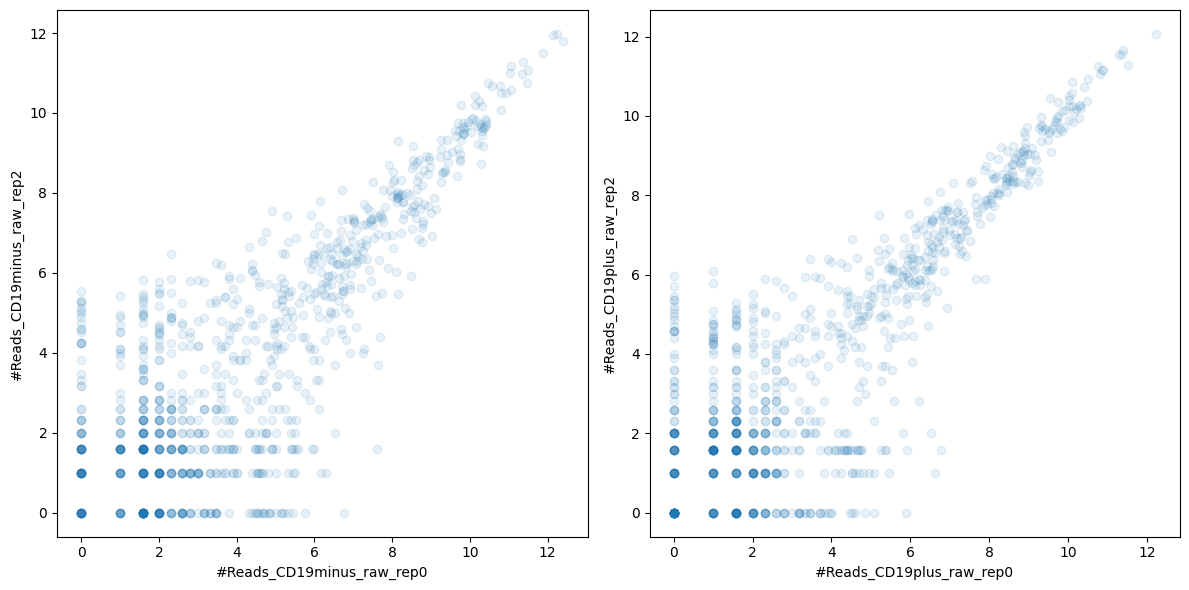

In [42]:
merged_encodings_millipede_rep0_rep2_minus_plus = merged_encodings_millipede_rep0_rep2[['#Reads_CD19minus_raw_rep0', '#Reads_CD19minus_raw_rep2', '#Reads_CD19plus_raw_rep0', '#Reads_CD19plus_raw_rep2',
                                                                                       '#Reads_CD19minus_rep0', '#Reads_CD19minus_rep2', '#Reads_CD19plus_rep0', '#Reads_CD19plus_rep2',
                                                                                       'score_rep0', 'score_rep2']]
merged_encodings_millipede_rep0_rep2_minus_plus = merged_encodings_millipede_rep0_rep2_minus_plus.dropna()
merged_encodings_millipede_rep0_rep2_minus_plus = merged_encodings_millipede_rep0_rep2_minus_plus.drop(merged_encodings_millipede_rep0_rep2_minus_plus.index[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatter plot
ax1.scatter(np.log2(merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19minus_raw_rep0']),
            np.log2(merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19minus_raw_rep2']),
            alpha=0.1)
ax1.set_xlabel('#Reads_CD19minus_raw_rep0')
ax1.set_ylabel('#Reads_CD19minus_raw_rep2')

# Plot the second scatter plot
ax2.scatter(np.log2(merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19plus_raw_rep0']),
            np.log2(merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19plus_raw_rep2']),
            alpha=0.1)
ax2.set_xlabel('#Reads_CD19plus_raw_rep0')
ax2.set_ylabel('#Reads_CD19plus_raw_rep2')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/MilliV2/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


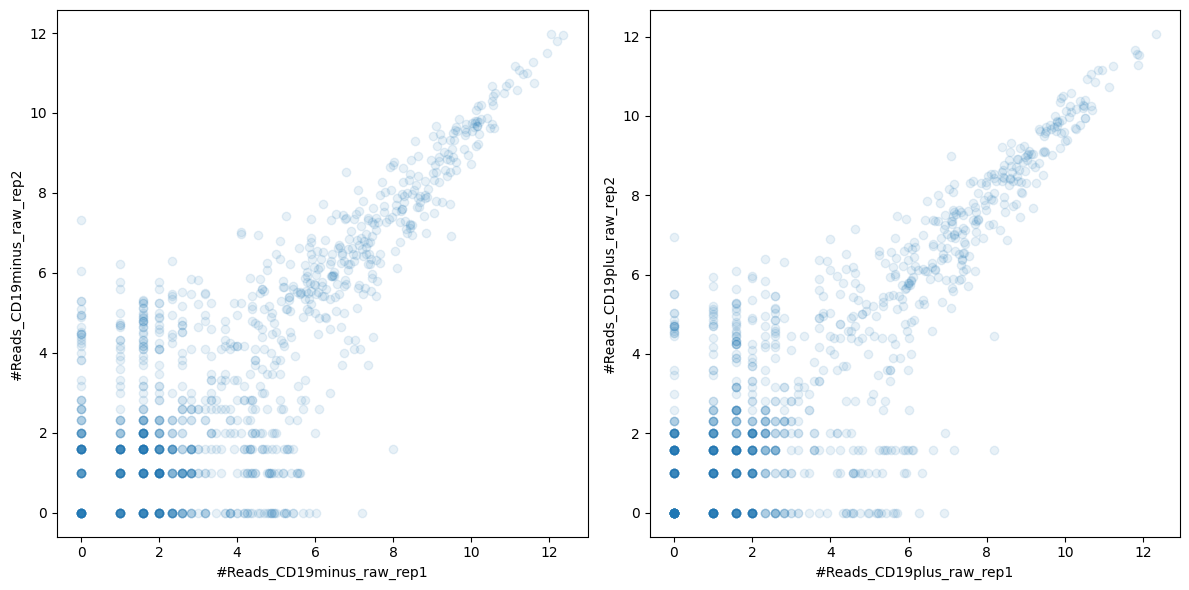

In [43]:
merged_encodings_millipede_rep1_rep2_minus_plus = merged_encodings_millipede_rep1_rep2[['#Reads_CD19minus_raw_rep1', '#Reads_CD19minus_raw_rep2', '#Reads_CD19plus_raw_rep1', '#Reads_CD19plus_raw_rep2',
                                                                                       '#Reads_CD19minus_rep1', '#Reads_CD19minus_rep2', '#Reads_CD19plus_rep1', '#Reads_CD19plus_rep2',
                                                                                       'score_rep1', 'score_rep2']]
merged_encodings_millipede_rep1_rep2_minus_plus = merged_encodings_millipede_rep1_rep2_minus_plus.dropna()
merged_encodings_millipede_rep1_rep2_minus_plus = merged_encodings_millipede_rep1_rep2_minus_plus.drop(merged_encodings_millipede_rep1_rep2_minus_plus.index[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatter plot
ax1.scatter(np.log2(merged_encodings_millipede_rep1_rep2_minus_plus['#Reads_CD19minus_raw_rep1']),
            np.log2(merged_encodings_millipede_rep1_rep2_minus_plus['#Reads_CD19minus_raw_rep2']),
            alpha=0.1)
ax1.set_xlabel('#Reads_CD19minus_raw_rep1')
ax1.set_ylabel('#Reads_CD19minus_raw_rep2')

# Plot the second scatter plot
ax2.scatter(np.log2(merged_encodings_millipede_rep1_rep2_minus_plus['#Reads_CD19plus_raw_rep1']),
            np.log2(merged_encodings_millipede_rep1_rep2_minus_plus['#Reads_CD19plus_raw_rep2']),
            alpha=0.1)
ax2.set_xlabel('#Reads_CD19plus_raw_rep1')
ax2.set_ylabel('#Reads_CD19plus_raw_rep2')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


In [44]:
merged_encodings_millipede_rep0_rep1_minus_plus['NormSumRep0'] = merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19plus_rep0'] + merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19minus_rep0']
merged_encodings_millipede_rep0_rep1_minus_plus['NormSumRep1'] = merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19plus_rep1'] + merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19minus_rep1']
merged_encodings_millipede_rep0_rep2_minus_plus['NormSumRep2'] = merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19plus_rep2'] + merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19minus_rep2']



/tmp/ipykernel_192927/2529737909.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.cut(df['NormSumRep0'], bins)


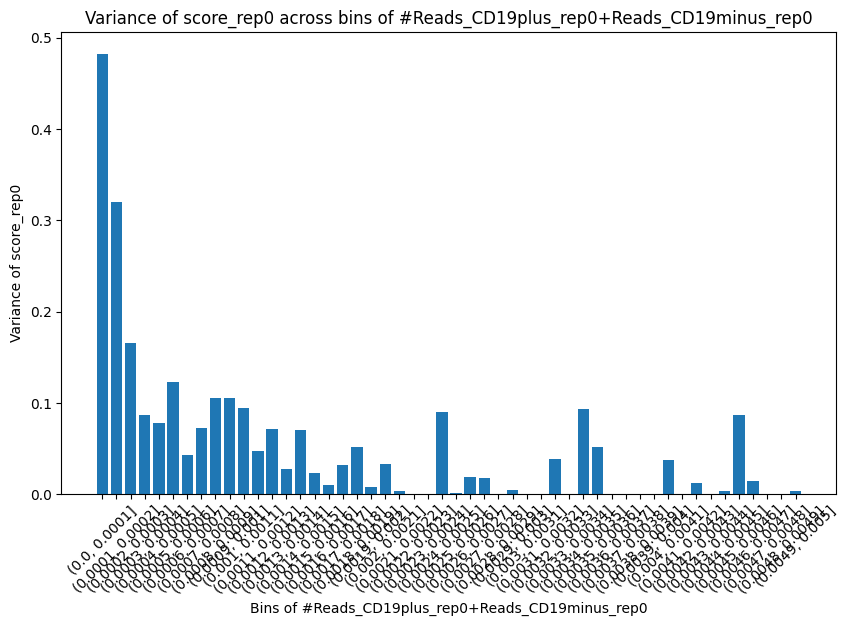

In [45]:
df = merged_encodings_millipede_rep0_rep1_minus_plus[['NormSumRep0', 'score_rep0']]

# Create bins
bin_width = 0.0001  # You can adjust this to 0.0005 or another value as needed
bins = np.arange(0, 0.005 + bin_width, bin_width)  # Create bins from 0 to 0.005 with the specified width

df['bins'] = pd.cut(df['NormSumRep0'], bins)

# Compute variance for each bin
variance_per_bin = df.groupby('bins')['score_rep0'].var().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(variance_per_bin['bins'].astype(str), variance_per_bin['score_rep0'], width=0.8)
plt.xlabel('Bins of #Reads_CD19plus_rep0+Reads_CD19minus_rep0')
plt.ylabel('Variance of score_rep0')
plt.title('Variance of score_rep0 across bins of #Reads_CD19plus_rep0+Reads_CD19minus_rep0')
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_192927/1520270563.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.cut(df['NormSumRep1'], bins)


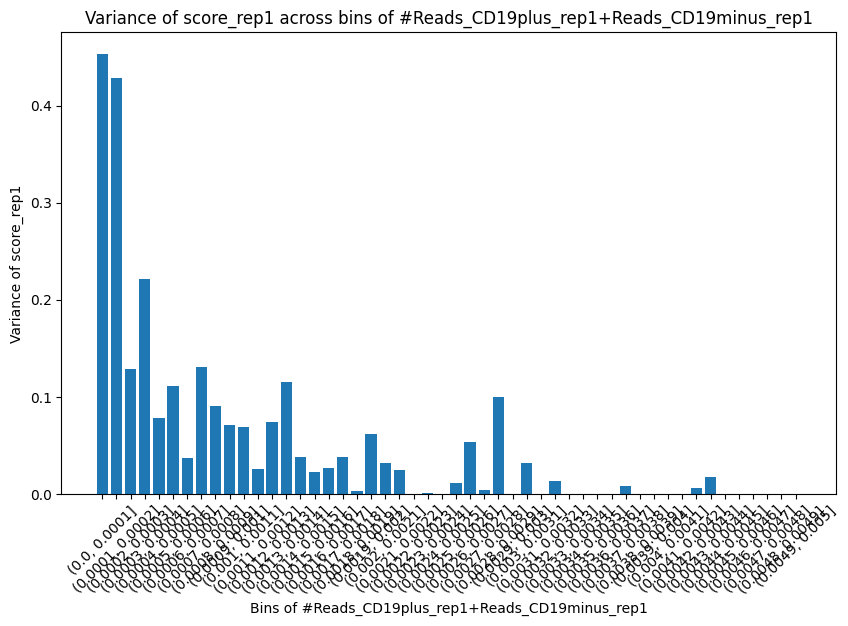

In [46]:
df = merged_encodings_millipede_rep0_rep1_minus_plus[['NormSumRep1', 'score_rep1']]

# Create bins
bin_width = 0.0001  # You can adjust this to 0.0005 or another value as needed
bins = np.arange(0, 0.005 + bin_width, bin_width)  # Create bins from 0 to 0.005 with the specified width

df['bins'] = pd.cut(df['NormSumRep1'], bins)

# Compute variance for each bin
variance_per_bin = df.groupby('bins')['score_rep1'].var().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(variance_per_bin['bins'].astype(str), variance_per_bin['score_rep1'], width=0.8)
plt.xlabel('Bins of #Reads_CD19plus_rep1+Reads_CD19minus_rep1')
plt.ylabel('Variance of score_rep1')
plt.title('Variance of score_rep1 across bins of #Reads_CD19plus_rep1+Reads_CD19minus_rep1')
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_192927/2244873421.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.cut(df['NormSumRep2'], bins)


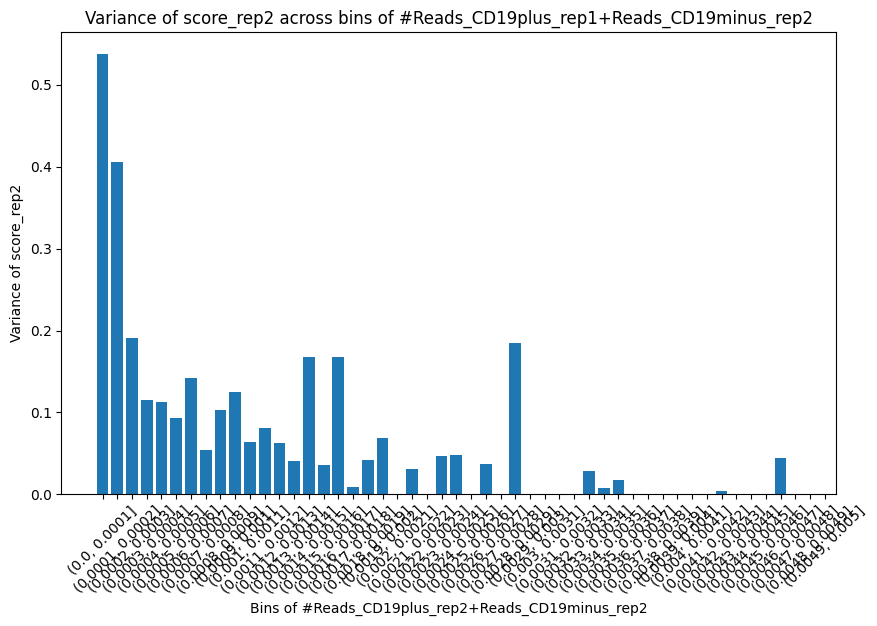

In [47]:
df = merged_encodings_millipede_rep0_rep2_minus_plus[['NormSumRep2', 'score_rep2']]

# Create bins
bin_width = 0.0001  # You can adjust this to 0.0005 or another value as needed
bins = np.arange(0, 0.005 + bin_width, bin_width)  # Create bins from 0 to 0.005 with the specified width

df['bins'] = pd.cut(df['NormSumRep2'], bins)

# Compute variance for each bin
variance_per_bin = df.groupby('bins')['score_rep2'].var().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(variance_per_bin['bins'].astype(str), variance_per_bin['score_rep2'], width=0.8)
plt.xlabel('Bins of #Reads_CD19plus_rep2+Reads_CD19minus_rep2')
plt.ylabel('Variance of score_rep2')
plt.title('Variance of score_rep2 across bins of #Reads_CD19plus_rep1+Reads_CD19minus_rep2')
plt.xticks(rotation=45)
plt.show()


In [48]:
def collapse_columns(df):
    
    df_a = df.copy()
    df_b = df.copy()
    df_c = df.copy()
    
    # Populate the reads column
    df_a['reads'] = df_a['#Reads_CD19minus_raw']
    df_b['reads'] = df_b['#Reads_CD19plus_raw']
    df_c['reads'] = df_c['#Reads_presort_raw']
    
    #Create indicator columns
    df_a['Minus'] = 1
    df_a['Plus'] = 0
    df_a['Presort'] = 0
    
    df_b['Minus'] = 0
    df_b['Plus'] = 1
    df_b['Presort'] = 0
    
    df_c['Minus'] = 0
    df_c['Plus'] = 0
    df_c['Presort'] = 1
    
    result_df = pd.concat([df_a, df_b, df_c], ignore_index = True)
    

    
    return result_df


In [49]:
dataCollapsed1 = collapse_columns(data1)
dataCollapsed2 = collapse_columns(data2)
dataCollapsed3 = collapse_columns(data3)
dataCollapsed3

,intercept_exp0_rep0,intercept_exp0_rep1,intercept_exp0_rep2,21T>C,23T>C,28A>G,31T>C,35T>C,36A>G,39T>C,...,#Reads_CD19minus_raw,#Reads_CD19plus_raw,#Reads_presort_raw,score,scale_factor,psi0,reads,Minus,Plus,Presort
0,0.0,0.0,1.0,0,0,0,0,0,0,0,...,285837.0,371719.0,285782.0,-0.025100,1.000000,12.562988,285837.0,1,0,0
1,0.0,0.0,1.0,0,0,0,0,0,0,0,...,505.0,552.0,219.0,0.061680,1.000087,5.393628,505.0,1,0,0
2,0.0,0.0,1.0,0,0,0,0,0,0,0,...,342.0,321.0,237.0,0.137070,1.005836,5.472271,342.0,1,0,0
3,0.0,0.0,1.0,0,0,0,0,0,0,0,...,173.0,373.0,202.0,-0.270951,1.039167,5.313206,173.0,1,0,0
4,0.0,0.0,1.0,0,0,0,0,0,0,0,...,107.0,190.0,170.0,-0.178898,1.228397,5.141664,107.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3889,0.0,0.0,1.0,1,1,0,0,0,0,0,...,2.0,5.0,0.0,-0.338053,4.732207,0.000000,0.0,0,0,1
3890,0.0,0.0,1.0,1,1,0,0,0,0,0,...,31.0,3.0,2.0,0.854862,3.870900,1.098612,2.0,0,0,1
3891,0.0,0.0,1.0,1,1,0,0,0,0,0,...,0.0,2.0,2.0,-1.000000,4.926897,1.098612,2.0,0,0,1
3892,0.0,0.0,1.0,1,1,0,0,0,0,0,...,0.0,1.0,0.0,-1.000000,4.963109,0.000000,0.0,0,0,1


In [50]:
final_df = pd.concat([dataCollapsed1, dataCollapsed2, dataCollapsed3], ignore_index = True)
final_df

,intercept_exp0_rep0,intercept_exp0_rep1,intercept_exp0_rep2,21T>C,23T>C,28A>G,31T>C,35T>C,36A>G,39T>C,...,#Reads_CD19minus_raw,#Reads_CD19plus_raw,#Reads_presort_raw,score,scale_factor,psi0,reads,Minus,Plus,Presort
0,1.0,0.0,0.0,0,0,0,0,0,0,0,...,359314.0,345867.0,305021.0,-0.033022,1.000000,12.628139,359314.0,1,0,0
1,1.0,0.0,0.0,0,0,0,0,0,0,0,...,856.0,463.0,524.0,0.249769,1.000176,6.263398,856.0,1,0,0
2,1.0,0.0,0.0,0,0,0,0,0,0,0,...,413.0,401.0,355.0,-0.037345,1.001715,5.874931,413.0,1,0,0
3,1.0,0.0,0.0,0,0,0,0,0,0,0,...,208.0,267.0,322.0,-0.175136,1.054813,5.777652,208.0,1,0,0
4,1.0,0.0,0.0,0,0,0,0,0,0,0,...,146.0,144.0,163.0,-0.045178,1.250407,5.099866,146.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11755,0.0,0.0,1.0,1,1,0,0,0,0,0,...,2.0,5.0,0.0,-0.338053,4.732207,0.000000,0.0,0,0,1
11756,0.0,0.0,1.0,1,1,0,0,0,0,0,...,31.0,3.0,2.0,0.854862,3.870900,1.098612,2.0,0,0,1
11757,0.0,0.0,1.0,1,1,0,0,0,0,0,...,0.0,2.0,2.0,-1.000000,4.926897,1.098612,2.0,0,0,1
11758,0.0,0.0,1.0,1,1,0,0,0,0,0,...,0.0,1.0,0.0,-1.000000,4.963109,0.000000,0.0,0,0,1


In [51]:
nt_columns = [col for col in final_df.columns if ">" in col]
final_df['Covariate_ID'] = final_df[nt_columns].astype(str).agg('_'.join, axis = 1)
final_df

,intercept_exp0_rep0,intercept_exp0_rep1,intercept_exp0_rep2,21T>C,23T>C,28A>G,31T>C,35T>C,36A>G,39T>C,...,#Reads_CD19plus_raw,#Reads_presort_raw,score,scale_factor,psi0,reads,Minus,Plus,Presort,Covariate_ID
0,1.0,0.0,0.0,0,0,0,0,0,0,0,...,345867.0,305021.0,-0.033022,1.000000,12.628139,359314.0,1,0,0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
1,1.0,0.0,0.0,0,0,0,0,0,0,0,...,463.0,524.0,0.249769,1.000176,6.263398,856.0,1,0,0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
2,1.0,0.0,0.0,0,0,0,0,0,0,0,...,401.0,355.0,-0.037345,1.001715,5.874931,413.0,1,0,0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
3,1.0,0.0,0.0,0,0,0,0,0,0,0,...,267.0,322.0,-0.175136,1.054813,5.777652,208.0,1,0,0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
4,1.0,0.0,0.0,0,0,0,0,0,0,0,...,144.0,163.0,-0.045178,1.250407,5.099866,146.0,1,0,0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11755,0.0,0.0,1.0,1,1,0,0,0,0,0,...,5.0,0.0,-0.338053,4.732207,0.000000,0.0,0,0,1,1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
11756,0.0,0.0,1.0,1,1,0,0,0,0,0,...,3.0,2.0,0.854862,3.870900,1.098612,2.0,0,0,1,1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
11757,0.0,0.0,1.0,1,1,0,0,0,0,0,...,2.0,2.0,-1.000000,4.926897,1.098612,2.0,0,0,1,1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
11758,0.0,0.0,1.0,1,1,0,0,0,0,0,...,1.0,0.0,-1.000000,4.963109,0.000000,0.0,0,0,1,1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...


In [52]:
# Step 1: Melt the dataframe to convert replicate indicators into a long format
melted_df = final_df.melt(id_vars=['Covariate_ID', '#Reads_CD19minus_raw', '#Reads_CD19plus_raw', '#Reads_presort_raw'], 
                          value_vars=['intercept_exp0_rep0', 'intercept_exp0_rep1', 'intercept_exp0_rep2'],
                          var_name='replicate', value_name='rep_value')

# Filter out rows where rep_value is 0
melted_df = melted_df[melted_df['rep_value'] == 1]

pivoted_df = melted_df.pivot_table(index='Covariate_ID', columns='replicate', 
                                   values=['#Reads_CD19minus_raw', '#Reads_CD19plus_raw', '#Reads_presort_raw'])



pivoted_df


#Reads_CD19minus_raw  \
replicate                                           intercept_exp0_rep0   
Covariate_ID                                                              
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...             359314.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                856.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                413.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                208.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                146.0   
...                                                                 ...   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  2.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  0.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  5.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  0.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  6.0   

                                                                        \
replicate                                          intercept_exp0_rep1   
Covariate_ID                                                             
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...            374063.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               677.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               397.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               441.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               165.0   
...                                                                ...   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 1.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 9.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 3.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 2.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 3.0   

                                                                        \
replicate                                          intercept_exp0_rep2   
Covariate_ID                                                             
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...            285837.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               505.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               342.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               173.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               107.0   
...                                                                ...   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 2.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                31.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 0.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 0.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 1.0   

                                                   #Reads_CD19plus_raw  \
replicate                                          intercept_exp0_rep0   
Covariate_ID                                                             
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...            345867.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               463.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               401.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               267.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...               144.0   
...                                                                ...   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 2.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                41.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 3.0   
1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_

In [53]:
# Flatten the multi-level columns
pivoted_df.columns = [f'{var}rep{rep}' for var, rep in pivoted_df.columns]

# Reset index to get Covariate_ID back as a column
pivoted_df.reset_index(inplace=True)

pivoted_df = pivoted_df.fillna(0)

# Create a mask where all values in the row are greater than 0
#mask = (pivoted_df.iloc[:, 1:] > 0).all(axis=1)

# Apply the mask to keep only rows where all columns have a value > 0
#pivoted_df = pivoted_df[mask]

#mask = (pivoted_df.iloc[:, 7:] > 50).all(axis=1) #PRESORT > 10
#pivoted_df = pivoted_df[mask]



pivoted_df

,Covariate_ID,#Reads_CD19minus_rawrepintercept_exp0_rep0,#Reads_CD19minus_rawrepintercept_exp0_rep1,#Reads_CD19minus_rawrepintercept_exp0_rep2,#Reads_CD19plus_rawrepintercept_exp0_rep0,#Reads_CD19plus_rawrepintercept_exp0_rep1,#Reads_CD19plus_rawrepintercept_exp0_rep2,#Reads_presort_rawrepintercept_exp0_rep0,#Reads_presort_rawrepintercept_exp0_rep1,#Reads_presort_rawrepintercept_exp0_rep2
0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,359314.0,374063.0,285837.0,345867.0,416616.0,371719.0,305021.0,325401.0,285782.0
1,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,856.0,677.0,505.0,463.0,707.0,552.0,524.0,786.0,219.0
2,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,413.0,397.0,342.0,401.0,471.0,321.0,355.0,311.0,237.0
3,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,208.0,441.0,173.0,267.0,275.0,373.0,322.0,406.0,202.0
4,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,146.0,165.0,107.0,144.0,162.0,190.0,163.0,172.0,170.0
...,...,...,...,...,...,...,...,...,...,...
1358,1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,2.0,1.0,2.0,2.0,3.0,5.0,0.0,2.0,0.0
1359,1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,0.0,9.0,31.0,41.0,6.0,3.0,2.0,32.0,2.0
1360,1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,5.0,3.0,0.0,3.0,40.0,2.0,1.0,0.0,2.0
1361,1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,0.0,2.0,0.0,3.0,4.0,1.0,0.0,0.0,0.0


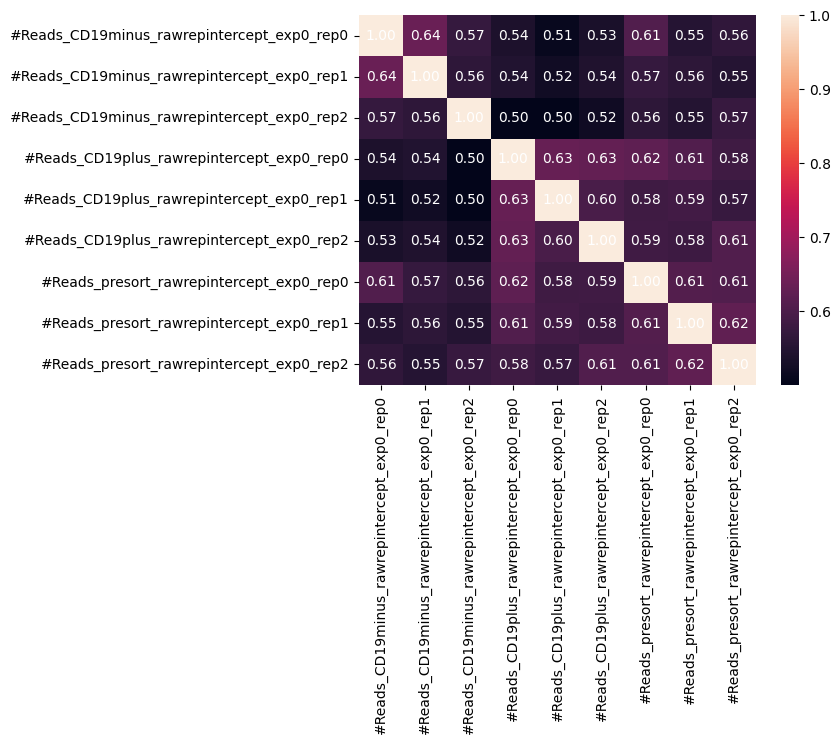

In [54]:
#Non Normalized Correlation Heatmap
import seaborn as sns

count_columns = [col for col in pivoted_df.columns if 'Reads' in col]
counts_df = pivoted_df[count_columns].transpose()

corr_df1 = counts_df.T.corr(method='spearman')


ax = sns.heatmap(corr_df1, annot=False)

# Loop over the data dimensions and create text annotations.
for i in range(corr_df1.shape[0]):
    for j in range(corr_df1.shape[1]):
        ax.text(j + 0.5, i + 0.5, 
                f'{corr_df1.iloc[i, j]:.2f}',  # Format the annotation as desired
                ha='center', va='center', color='white')

plt.show()



## Run Millipede

In [55]:
%%time
from crispr_millipede import encoding as cme
from crispr_millipede import modelling as cmm

paired_end_experiments_models_denoised = cmm.MillipedeModelExperimentalGroup(experiments_inputdata=paired_end_experiments_inputdata_denoised, device=cmm.MillipedeComputeDevice.GPU)


Start model inference for all provided model specifications: 1 total
Starting model inference for model specification id 1/1: joint_replicate_per_experiment_models
Number of single matrices: 1
With 2 model types, the total models to inference for this model specification: 2
Running model(s) for single matrix index: 1/1
Iterating through all 2 provided models: 
Preparing data for model NORMAL_SIGMA_SCALED, 1/2
Running model NORMAL_SIGMA_SCALED


  0%|          | 0/5500 [00:00<?, ?it/s]

Preparing data for model NORMAL, 2/2
Running model NORMAL


  0%|          | 0/5500 [00:00<?, ?it/s]

CPU times: user 36.9 s, sys: 729 ms, total: 37.7 s
Wall time: 35.2 s


In [56]:
beta_df = paired_end_experiments_models_denoised.millipede_model_specification_set_with_results['joint_replicate_per_experiment_models'].millipede_model_specification_result_input[0].millipede_model_specification_single_matrix_result[cmm.MillipedeModelType.NORMAL_SIGMA_SCALED].beta
pip_df = paired_end_experiments_models_denoised.millipede_model_specification_set_with_results['joint_replicate_per_experiment_models'].millipede_model_specification_result_input[0].millipede_model_specification_single_matrix_result[cmm.MillipedeModelType.NORMAL_SIGMA_SCALED].pip
display(beta_df.sort_values(ascending=False).head(40))
display(pip_df.sort_values(ascending=False).head(40))

223A>G                 0.360295
151A>G                 0.256621
137T>C                 0.236218
230A>G                 0.194456
176T>C                 0.110696
311A>G                 0.083927
Intercept              0.052212
158A>G                 0.043610
148T>C                 0.037574
314A>G                 0.032944
318A>G                 0.025297
308T>C                 0.021423
296T>C                 0.018450
intercept_exp0_rep1    0.015229
intercept_exp0_rep0    0.013960
320A>G                 0.005127
41A>G                  0.004299
283T>C                 0.003783
252A>G                 0.003323
220A>G                 0.003047
218A>G                 0.002938
287T>C                 0.002714
302A>G                 0.002237
304T>C                 0.002173
131T>C                 0.001664
185T>C                 0.001660
324A>G                 0.001565
300T>C                 0.001542
297T>C                 0.001388
321A>G                 0.001078
28A>G                  0.001066
254T>C  

223A>G    0.999999
137T>C    0.999997
151A>G    0.998023
230A>G    0.983824
311A>G    0.567388
176T>C    0.423963
148T>C    0.336893
314A>G    0.303642
158A>G    0.267604
270T>C    0.242251
318A>G    0.231568
248T>C    0.205609
308T>C    0.119563
106T>C    0.078285
105A>G    0.072801
112T>C    0.063570
242T>C    0.055694
296T>C    0.047011
241A>G    0.042978
283T>C    0.039807
320A>G    0.037763
220A>G    0.031545
62T>C     0.031200
65T>C     0.028891
304T>C    0.026538
239A>G    0.025742
252A>G    0.024361
41A>G     0.019224
287T>C    0.018449
113T>C    0.017763
300T>C    0.016633
60T>C     0.015111
116T>C    0.012792
324A>G    0.012526
59T>C     0.012260
131T>C    0.012206
228A>G    0.011461
302A>G    0.011012
319A>G    0.010843
52A>G     0.010407
Name: PIP, dtype: float64

In [114]:
paired_merged_raw_encodings = cmm.RawEncodingDataframesExperimentalGroup().read_in_files_constructor(
    enriched_pop_fn_encodings_experiment_list = ["./20240807_v0_1_84_encoding_dataframes_denoised_removed_CD19minus_ABE8e_encodings_rep{}.pkl"],
    baseline_pop_fn_encodings_experiment_list = ["./20240807_v0_1_84_encoding_dataframes_denoised_removed_CD19plus_ABE8e_encodings_rep{}.pkl"],
    presort_pop_fn_encodings_experiment_list = ["./20240807_v0_1_84_encoding_dataframes_denoised_removed_presort_ABE8e_encodings_rep{}.pkl"],
    experiment_labels = ["ABE8e"],
    ctrl_pop_fn_encodings="./20240807_v0_1_84_encoding_dataframes_denoised_removed_wt_encodings_rep0.pkl",
    ctrl_pop_labels="WT",
    reps = [0,1,2],
   )


['./20240807_v0_1_84_encoding_dataframes_denoised_removed_CD19minus_ABE8e_encodings_rep{}.pkl']
Reading enriched population...
Reading baseline population...
Reading presort population if provided...
Reading control population if provided...
Passed post-validation


In [115]:
# #Extracting editing frequencies
# paired_merged_raw_encodings = cmm.RawEncodingDataframesExperimentalGroup().read_in_files_constructor(
#     enriched_pop_fn_encodings_experiment_list=["./20240901_v0_1_89_encoding_dataframes_denoised_nonposition_nontrimmed_removed_CD19minus_ABE8e_encodings_rep{}.pkl"],
#     baseline_pop_fn_encodings_experiment_list=["./20240901_v0_1_89_encoding_dataframes_denoised_nonposition_nontrimmed_removed_CD19plus_ABE8e_encodings_rep{}.pkl"], 
#     presort_pop_fn_encodings_experiment_list=["./20240901_v0_1_89_encoding_dataframes_denoised_nonposition_nontrimmed_removed_presort_ABE8e_encodings_rep{}.pkl"],
#     experiment_labels=["ABE8e"],
#     ctrl_pop_fn_encodings="./20240901_v0_1_89_encoding_dataframes_denoised_nonposition_nontrimmed_removed_wt_encodings_rep0.pkl",
#     ctrl_pop_labels="WT",
#     reps=[0,1,2])
# paired_merged_raw_encodings_editing_freqs = cmm.EncodingEditingFrequenciesExperimentalGroup(paired_merged_raw_encodings)

In [116]:
paired_merged_raw_encodings_editing_freqs.presort_pop_encoding_editing_per_variant_freq_avg[0].to_csv('presort_editing_freqs_avg_ABE8e_1_89.csv')
paired_merged_raw_encodings_editing_freqs.baseline_pop_encoding_editing_per_variant_freq_avg[0].to_csv('baseline_editing_freqs_avg_ABE8e_1_89.csv')
paired_merged_raw_encodings_editing_freqs.enriched_pop_encoding_editing_per_variant_freq_avg[0].to_csv('enriched_editing_freqs_avg_ABE8e_1_89.csv')
paired_merged_raw_encodings_editing_freqs.ctrl_pop_encoding_editing_per_variant_freq_avg[0].to_csv('wt_editing_freqs_avg_ABE8e_1_89.csv')

In [117]:
sigma_hit_table = paired_end_experiments_models_denoised.millipede_model_specification_set_with_results["joint_replicate_per_experiment_models"].millipede_model_specification_result_input[0].millipede_model_specification_single_matrix_result[cmm.MillipedeModelType.NORMAL_SIGMA_SCALED].summary
sigma_hit_table.to_csv('CD19_ABE8e_sigma_hit_table_ZP.csv', index=True)
sigma_hit_table

,PIP,Coefficient,Coefficient StdDev,Conditional Coefficient,Conditional Coefficient StdDev
21T>C,0.002079,0.000057,0.002054,0.033305,0.036591
23T>C,0.001627,0.000081,0.002558,0.041877,0.040324
28A>G,0.009664,0.001066,0.010257,0.083130,0.037150
31T>C,0.003243,0.000404,0.009140,0.074057,0.099380
35T>C,0.001179,0.000004,0.000438,0.042920,0.000000
...,...,...,...,...,...
324A>G,0.012526,0.001565,0.013515,0.101982,0.040786
intercept_exp0_rep0,NaN,0.013960,0.013531,0.013960,0.013531
intercept_exp0_rep1,NaN,0.015229,0.013990,0.015229,0.013990
intercept_exp0_rep2,NaN,-0.028532,0.014108,-0.028532,0.014108


In [118]:
normal_hit_table = paired_end_experiments_models_denoised.millipede_model_specification_set_with_results["joint_replicate_per_experiment_models"].millipede_model_specification_result_input[0].millipede_model_specification_single_matrix_result[cmm.MillipedeModelType.NORMAL].summary
normal_hit_table.to_csv('CD19_ABE8e_normal_hit_table_ZP.csv', index=True)

In [20]:
def millipede_dataframe_cleanup(path):

    millipede_dataframe = pd.read_csv(path, index_col = 0)
    millipede_dataframe.reset_index(drop=False, inplace=True)

    #CleanUp dataframe

    millipede_dataframe[['MainIndex','Base','Waste','BaseChange']] = millipede_dataframe['index'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')
    # millipede_dataframe = millipede_dataframe.dropna()
    millipede_dataframe['BaseChange'] = millipede_dataframe.apply(lambda x: x['Base'] if x['BaseChange']=="-" else x['BaseChange'], axis=1)
    millipede_dataframe['FinalIndex'] = millipede_dataframe['MainIndex'] + millipede_dataframe['Base']
    millipede_dataframe = millipede_dataframe[millipede_dataframe['BaseChange'] != 'N']


    #Generate Betas dataframe
    millipede_dataframe_Betas = millipede_dataframe[['FinalIndex','BaseChange','Coefficient','MainIndex','Base']]
    millipede_dataframe_Betas['MainIndex'] = millipede_dataframe_Betas['MainIndex'].astype(float)
    millipede_dataframe_Betas = millipede_dataframe_Betas.sort_values(by='MainIndex', ascending=True)


    #Generate PIPS dataframe
    millipede_dataframe_PIPS = millipede_dataframe[['FinalIndex','BaseChange','PIP','MainIndex','Base']]
    millipede_dataframe_PIPS['MainIndex'] = millipede_dataframe['MainIndex'].astype(float)
    millipede_dataframe_PIPS = millipede_dataframe_PIPS.sort_values(by='MainIndex', ascending=True)

    #Pivot the Betas dataframe
    
    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas.pivot_table(values='Coefficient', index='BaseChange', columns=['MainIndex','Base'])
    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas_pivot.replace(-9999, np.nan)

    for column in millipede_dataframe_Betas_pivot.columns:
        # Get the Base value for the current column
        base_value = column[1]

        # Set the value at the identified row and column to 0
        millipede_dataframe_Betas_pivot.at[base_value, column] = 0


    #Pivot the PIPS dataframe
    millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS.pivot_table(values='PIP', index='BaseChange', columns=['MainIndex','Base'])
    millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS_pivot.replace(-9999, np.nan)

    for column in millipede_dataframe_PIPS_pivot.columns:
        # Get the Base value for the current column
        base_value = column[1]

        # Set the value at the identified row and column to 0
        millipede_dataframe_PIPS_pivot.at[base_value, column] = 0
    millipede_dataframe_Betas_pivot.iloc[0, 136] = 0.25     # Set the value in the first row of the first column to 0
    millipede_dataframe_Betas_pivot.iloc[1, 136] = 0.25  # Set the value in the second row of the first column to 0.25
    millipede_dataframe_Betas_pivot.iloc[2, 136] = 0.25   # Set the value in the third row of the first column to 0.5
    millipede_dataframe_Betas_pivot.iloc[3, 136] = 0.25
    
    millipede_dataframe_PIPS_pivot.iloc[0, 136] = 0     # Set the value in the first row of the first column to 0
    millipede_dataframe_PIPS_pivot.iloc[1, 136] = 0.25  # Set the value in the second row of the first column to 0.25
    millipede_dataframe_PIPS_pivot.iloc[2, 136] = 0.5   # Set the value in the third row of the first column to 0.5
    millipede_dataframe_PIPS_pivot.iloc[3, 136] = 0.75


    return millipede_dataframe_Betas_pivot, millipede_dataframe_PIPS_pivot

def edit_dataframe_cleanup(PresortPath, WTPath):
    presort = pd.read_csv(PresortPath)
    WT = pd.read_csv(WTPath)

    # Step 2: Rename the 'editing efficiency' columns for clarity
    presort = presort.rename(columns={'Editing Efficiency': 'EditingEfficiencyPresort'})
    WT = WT.rename(columns={'Editing Efficiency': 'EditingEfficiencyWT'})

    # Step 3: Merge the DataFrames on the 'edits' column\
    merged_df = pd.merge(presort[['Edit', 'EditingEfficiencyPresort']], WT[['Edit', 'EditingEfficiencyWT']], on='Edit')
    merged_df['EditingRatio'] = merged_df['EditingEfficiencyPresort']/merged_df['EditingEfficiencyWT']
    merged_df[['MainIndex','Base','Waste','BaseChange']] = merged_df['Edit'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')
    # merged_df = merged_df.dropna()
    merged_df['BaseChange'] = merged_df.apply(lambda x: x['Base'] if x['BaseChange']=="-" else x['BaseChange'], axis=1)
    merged_df['FinalIndex'] = merged_df['MainIndex'] + merged_df['Base']
    merged_df = merged_df[merged_df['BaseChange'] != 'N']

    merged_df_ratios = merged_df[['FinalIndex','BaseChange','EditingRatio','MainIndex','Base']]
    merged_df_ratios['MainIndex'] = merged_df_ratios['MainIndex'].astype(float)
    merged_df_ratios = merged_df_ratios.sort_values(by='MainIndex', ascending=True)

    #fill NaN values with -9999
    merged_df_ratios = merged_df_ratios.fillna(-9999)
    merged_df_pivot = merged_df_ratios.pivot_table(values='EditingRatio', index='BaseChange', columns=['MainIndex','Base'])
    merged_df_pivot = merged_df_pivot.replace(-9999, np.nan)

    display(merged_df_pivot)
    binarized_df_pivot = merged_df_pivot >= 1.5
    binarized_df_pivot = binarized_df_pivot.astype(float)

    for column in binarized_df_pivot.columns:
      # Get the Base value for the current column
        base_value = column[1]

      # Find the index of the row corresponding to the Base value
    #   row_index = binarized_df_pivot.index.get_loc(base_value)

      # Set the value at the identified row and column to 0
        binarized_df_pivot.at[base_value, column] = 1

        # Initialize an empty list to store the data for the new DataFrame
    df_edit = []

    # Loop through each column of the original DataFrame
    for col in binarized_df_pivot.columns:
        # Get the base level for the column
        base = binarized_df_pivot[col].name[1]

        # Get the values for the column (excluding the 'Base' row)
        values = binarized_df_pivot[col].values

        # Check if more than one row has a value greater than 0
        edit_value = 1 if sum(values > 0) > 1 else 0

        # Append the data to the new_data list
        df_edit.append([base, edit_value])

    # Create the new DataFrame with columns "base" and "edit"
    df_edit = pd.DataFrame(df_edit, columns=['base', 'edit'])

    # Filter the rows with 'edit' value equal to 1
    filtered_rows = df_edit[df_edit['edit'] == 1]

    # Get the index values of the filtered rows and put them into a list
    orange_labels = filtered_rows.index.tolist()

    return binarized_df_pivot, orange_labels


In [13]:
def millipede_dataframe_cleanupV2(path):

    millipede_dataframe = pd.read_csv(path, index_col = 0)
    millipede_dataframe.reset_index(drop=False, inplace=True)

    #CleanUp dataframe

    millipede_dataframe[['MainIndex','Base','Waste','BaseChange']] = millipede_dataframe['index'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')
    # millipede_dataframe = millipede_dataframe.dropna()
    millipede_dataframe['BaseChange'] = millipede_dataframe.apply(lambda x: x['Base'] if x['BaseChange']=="-" else x['BaseChange'], axis=1)
    millipede_dataframe['FinalIndex'] = millipede_dataframe['MainIndex'] + millipede_dataframe['Base']
    millipede_dataframe = millipede_dataframe[millipede_dataframe['BaseChange'] != 'N']


    #Generate Betas dataframe
    millipede_dataframe_Betas = millipede_dataframe[['FinalIndex','BaseChange','Coefficient','MainIndex','Base']]
    millipede_dataframe_Betas['MainIndex'] = millipede_dataframe_Betas['MainIndex'].astype(float)
    millipede_dataframe_Betas = millipede_dataframe_Betas.sort_values(by='MainIndex', ascending=True)


    #Generate PIPS dataframe
    millipede_dataframe_PIPS = millipede_dataframe[['FinalIndex','BaseChange','PIP','MainIndex','Base']]
    millipede_dataframe_PIPS['MainIndex'] = millipede_dataframe['MainIndex'].astype(float)
    millipede_dataframe_PIPS = millipede_dataframe_PIPS.sort_values(by='MainIndex', ascending=True)
    

    #Pivot the Betas dataframe
    
    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas.pivot_table(values='Coefficient', index='BaseChange', columns=['MainIndex','Base'])
    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas_pivot.replace(-9999, np.nan)

    for column in millipede_dataframe_Betas_pivot.columns:
        # Get the Base value for the current column
        base_value = column[1]

        # Set the value at the identified row and column to 0
        millipede_dataframe_Betas_pivot.at[base_value, column] = 0


    #Pivot the PIPS dataframe
    millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS.pivot_table(values='PIP', index='BaseChange', columns=['MainIndex','Base'])
    millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS_pivot.replace(-9999, np.nan)

    for column in millipede_dataframe_PIPS_pivot.columns:
        # Get the Base value for the current column
        base_value = column[1]

        # Set the value at the identified row and column to 0
        millipede_dataframe_PIPS_pivot.at[base_value, column] = 0
    
    Variant = millipede_dataframe_Betas_pivot.fillna(0)
    arr = Variant.iloc[:4, :346].values
    
    dfVariant = pd.DataFrame(arr)
    dfVariant = dfVariant.T  # Transpose the dataframe
    dfVariant.columns = ['A', 'C', 'G', 'T']  # Set the column names
    dfVariant.index.name = 'pos'  # Set the index name

    return millipede_dataframe_Betas_pivot, millipede_dataframe_PIPS_pivot, dfVariant

def edit_dataframe_cleanupV2(PresortPath, WTPath):
    presort = pd.read_csv(PresortPath)
    WT = pd.read_csv(WTPath)

    # Step 2: Rename the 'editing efficiency' columns for clarity
    presort = presort.rename(columns={'Editing Efficiency': 'EditingEfficiencyPresort'})
    WT = WT.rename(columns={'Editing Efficiency': 'EditingEfficiencyWT'})

    # Step 3: Merge the DataFrames on the 'edits' column\
    merged_df = pd.merge(presort[['Edit', 'EditingEfficiencyPresort']], WT[['Edit', 'EditingEfficiencyWT']], on='Edit')
    merged_df['EditingRatio'] = merged_df['EditingEfficiencyPresort']/merged_df['EditingEfficiencyWT']
    merged_df[['MainIndex','Base','Waste','BaseChange']] = merged_df['Edit'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')
    # merged_df = merged_df.dropna()
    merged_df['BaseChange'] = merged_df.apply(lambda x: x['Base'] if x['BaseChange']=="-" else x['BaseChange'], axis=1)
    merged_df['FinalIndex'] = merged_df['MainIndex'] + merged_df['Base']
    merged_df = merged_df[merged_df['BaseChange'] != 'N']

    merged_df_ratios = merged_df[['FinalIndex','BaseChange','EditingRatio','MainIndex','Base']]
    merged_df_ratios['MainIndex'] = merged_df_ratios['MainIndex'].astype(float)
    merged_df_ratios = merged_df_ratios.sort_values(by='MainIndex', ascending=True)

    #fill NaN values with -9999
    merged_df_ratios = merged_df_ratios.fillna(-9999)
    merged_df_pivot = merged_df_ratios.pivot_table(values='EditingRatio', index='BaseChange', columns=['MainIndex','Base'])
    merged_df_pivot = merged_df_pivot.replace(-9999, np.nan)

    display(merged_df_pivot)
    binarized_df_pivot = merged_df_pivot >= 1.5
    binarized_df_pivot = binarized_df_pivot.astype(float)

    for column in binarized_df_pivot.columns:
      # Get the Base value for the current column
        base_value = column[1]

      # Find the index of the row corresponding to the Base value
    #   row_index = binarized_df_pivot.index.get_loc(base_value)

      # Set the value at the identified row and column to 0
        binarized_df_pivot.at[base_value, column] = 1

        # Initialize an empty list to store the data for the new DataFrame
    df_edit = []

    # Loop through each column of the original DataFrame
    for col in binarized_df_pivot.columns:
        # Get the base level for the column
        base = binarized_df_pivot[col].name[1]

        # Get the values for the column (excluding the 'Base' row)
        values = binarized_df_pivot[col].values

        # Check if more than one row has a value greater than 0
        edit_value = 1 if sum(values > 0) > 1 else 0

        # Append the data to the new_data list
        df_edit.append([base, edit_value])

    # Create the new DataFrame with columns "base" and "edit"
    df_edit = pd.DataFrame(df_edit, columns=['base', 'edit'])

    # Filter the rows with 'edit' value equal to 1
    filtered_rows = df_edit[df_edit['edit'] == 1]

    # Get the index values of the filtered rows and put them into a list
    orange_labels = filtered_rows.index.tolist()

    return binarized_df_pivot, orange_labels


In [18]:
def plot_millipede_heatmapV2(path, pathPresort, pathWT):
    millipede_dataframe_Betas_pivot, millipede_dataframe_PIPS_pivot = millipede_dataframe_cleanup(path)
    binarized_df, orange_labels = edit_dataframe_cleanup(pathPresort, pathWT)

    display(binarized_df)

    # display(millipede_dataframe_Betas_pivot)
    # display(millipede_dataframe_PIPS_pivot)
    # display(binarized_df)
    # display(orange_labels)

    # Check if dataframes are loaded
    if millipede_dataframe_Betas_pivot is None or millipede_dataframe_PIPS_pivot is None:
        print("Data not loaded properly")
        return
    start = 136
    end = 176

    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas_pivot.iloc[:, start:end]
    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas_pivot.fillna(0)
    display(millipede_dataframe_Betas_pivot)
    millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS_pivot.iloc[:, start:end]
    binarized_df = binarized_df.iloc[:, start:end]
    #orange_labels = [i for i in orange_labels if i >= start and i < end]
    orange_labels = [i - start for i in orange_labels if i >= start and i < end]


    # millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS_pivot.iloc[:, start:end]
    #print(millipede_dataframe_PIPS_pivot)


    # Dimensions of the figure in inches
    fig_width, fig_height = 8, 2
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Determine grid dimensions
    grid_rows, grid_cols = millipede_dataframe_Betas_pivot.shape

    # Generate coordinates
    x = np.arange(grid_cols)
    y = np.arange(grid_rows)
    X, Y = np.meshgrid(x, y)

    # Draw grid lines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
    ax.set_xticks(np.arange(-0.5, grid_cols, 1), minor=False)
    ax.set_yticks(np.arange(-0.5, grid_rows, 1), minor=False)

    # Calculate the size of the axes in points
    fig.canvas.draw()  # This is required to update the figure and axes bounds
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axes_width_pt, axes_height_pt = bbox.width * fig.dpi, bbox.height * fig.dpi

    # Calculate the size of a single grid square in points
    grid_square_width_pt = axes_width_pt / grid_cols
    grid_square_height_pt = axes_height_pt / grid_rows
    grid_square_side_pt = min(grid_square_width_pt, grid_square_height_pt)
    base_size = grid_square_side_pt ** 2

    print("Width of a single grid square in points:", grid_square_width_pt)
    print("Height of a single grid square in points:", grid_square_height_pt)
    print("Side of a single grid square in points:", grid_square_side_pt)
    print("Base size:", base_size)
    print("Max Beta Value:", millipede_dataframe_Betas_pivot.values.max())
    print("Min Beta Value:", millipede_dataframe_Betas_pivot.values.min())


    # Normalize the colors to the range of Betas_pivot values
    norm = plt.Normalize(vmin=-millipede_dataframe_Betas_pivot.values.max(), vmax=millipede_dataframe_Betas_pivot.values.max())

    # Normalize the PIPS values
    max_pips_value = 1
    normalized_pips_values = millipede_dataframe_PIPS_pivot.values / max_pips_value

    size_reduction_factor = 0.5

    # Calculate the size of each square in the scatter plot
    size = normalized_pips_values * base_size * size_reduction_factor
    # print(size.max())

    # Use scatter plot to color squares
    squares = ax.scatter(X.flatten(), Y.flatten(), s=size.flatten(), c=millipede_dataframe_Betas_pivot.values.flatten(), linewidth=0,  cmap='RdBu_r', marker='s', norm=norm, edgecolors='black')

    #Iterate over each square in the binarized DataFrame and add a rectangular patch with a gray facecolor
    for xi, yi, s, val in zip(X.flatten(), Y.flatten(), size.flatten(), binarized_df.values.flatten()):
        if val == 0:
            rect = patches.Rectangle((xi - 0.5, yi - 0.5), 1, 1, linewidth=0, facecolor='gray', alpha=0.5)
            ax.add_patch(rect)

    # Set aspect ratio
    ax.set_aspect('equal')

    # Set the limits of the axes to cover the entire image area
    ax.set_xlim(-0.5, grid_cols - 0.5)
    ax.set_ylim(-0.5, grid_rows - 0.5)

    #ax.set_xticklabels([])
    #ax.set_yticklabels([])

    # Names for the y-axis labels
    y_labels = ['A', 'C', 'G', 'T']

    ax.set_yticks(np.arange(0.5, grid_rows, 1))
    ax.set_xticks(np.arange(0.5, grid_cols, 1))

    # Set the y-tick labels
    ax.set_yticklabels(y_labels, fontsize = grid_square_width_pt/1.75, verticalalignment='top')

    # Get the tick labels from the second level of the multi-level column index
    tick_labels = millipede_dataframe_Betas_pivot.columns.get_level_values(1)

    # Set the rotation and alignment of the tick labels
    ax.set_xticklabels(tick_labels, rotation=0, ha='right', fontsize = grid_square_width_pt/1.75)

    # Function to add circles to the heatmap cells
    def add_circle(ax, x, y, radius, color):
        circle = plt.Circle((x, y), radius, edgecolor=color, alpha=0.5, linewidth=0.5, fill=False)
        ax.add_patch(circle)

    # Loop through the columns and add circles in the corresponding rows
    for i, column in enumerate(millipede_dataframe_Betas_pivot.columns.get_level_values(1)):
        add_circle(ax, i, millipede_dataframe_Betas_pivot.index.get_loc(column), radius=0.2, color='black')

    for idx, label in enumerate(ax.get_xticklabels()):
        if idx in orange_labels:
            label.set_color('orange')
    # Create a color bar
    cbar = fig.colorbar(squares, ax=ax, orientation = 'horizontal', fraction=0.046)

    # Optionally, add a label to the color bar
    cbar.set_label('Betas', fontsize= grid_square_width_pt/1.5 )
    cbar.ax.tick_params(labelsize=grid_square_width_pt/1.75)

    base_path = path.replace(".csv", "")  # This removes '.csv' from the end
    pdf_path = base_path + "_MYBwPIP" + ".pdf"
    svg_path = base_path + "_MYBwPIP" + ".svg"

    fig.savefig(pdf_path, format='svg')
    fig.savefig(svg_path, format='pdf')

    plt.show()


In [156]:
#Adding placeholder zeros to sigma-hits table
sigma_hits = pd.read_csv('CD19_ABE8e_sigma_hit_table_ZP.csv')
amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

mapping_dict = {"A":"A>C","C":"C>A", "G":"G>T", "T":"T>A"}
#smaller df to add to sigma hits
for idx, base in enumerate(amplicon):
    #append new row with pos
    sigma_hits = sigma_hits.append({'Unnamed: 0': f"{idx}{mapping_dict[base]}"}, ignore_index=True)

sigma_hits["sort_column"] = sigma_hits['Unnamed: 0'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)

sigma_hits = sigma_hits.sort_values(by="sort_column")
sigma_hits = sigma_hits.drop(columns=["sort_column"])

sigma_hits.set_index('Unnamed: 0', inplace=True)
sigma_hits.index.name = None

sigma_hits.fillna(-9999).to_csv('CD19_ABE8e_sigma_hit_table_everything.csv')

In [123]:
# presort_editing = pd.read_csv('presort_editing_freqs_avg_ABE8e_1_89.csv')
# wt_editing = pd.read_csv('wt_editing_freqs_avg_ABE8e_1_89.csv')
# amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

# for idx, base in enumerate(amplicon):
#     #append new row with pos
#     if f"{idx}A>G" in wt_editing["FullChange"].values:
#         continue
#     if f"{idx}T>C" in wt_editing["FullChange"].values:
#         continue
#     presort_editing = presort_editing.append({'FullChange': f"{idx}X>X", "0":0}, ignore_index=True)
#     wt_editing = wt_editing.append({'FullChange': f"{idx}X>X", "0":0}, ignore_index=True)

# presort_editing["sort_column"] = presort_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)
# wt_editing["sort_column"] = wt_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)

# presort_editing = presort_editing.sort_values(by="sort_column")
# wt_editing = wt_editing.sort_values(by="sort_column")

# presort_editing = presort_editing.drop(columns=["sort_column"])
# wt_editing = wt_editing.drop(columns=["sort_column"])

# presort_editing.columns = ["Edit", "Editing Efficiency"]
# wt_editing.columns = ["Edit", "Editing Efficiency"]

# presort_editing.set_index('Edit', inplace=True)
# wt_editing.set_index('Edit', inplace=True)

# presort_editing.to_csv("presort_editing_freqs_avg_ABE8e_1_89_everything.csv")
# wt_editing.to_csv("wt_editing_freqs_avg_ABE8e_1_89_everything.csv")

# editing_diff = pd.merge(presort_editing, wt_editing, left_index=True, right_index=True, how='left', suffixes=('_presort', '_wt'))
# editing_diff["Diff"] = editing_diff["Editing Efficiency_presort"] - editing_diff["Editing Efficiency_wt"]
# #replace 0 in Diff with NaN
# editing_diff["Diff"] = editing_diff["Diff"].replace(0, np.nan)
# editing_diff["Pos"] = editing_diff.index.str.split(">").str[0].str[:-1]
# editing_diff_bedgraph = editing_diff[["Pos", "Editing Efficiency_presort", "Editing Efficiency_wt"]]
# editing_diff_bedgraph["Start"] = editing_diff_bedgraph["Pos"].astype(int)+28930687
# editing_diff_bedgraph["End"] = editing_diff_bedgraph["Start"]+1
# editing_diff_bedgraph["chr16"] = "chr16"
# #drop any index with X in
# # editing_diff_bedgraph = editing_diff_bedgraph[~editing_diff_bedgraph.index.str.contains("X")]
# editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_presort"]].to_csv('presort_ABE8e_editing_efficiency.bedgraph', sep="\t", header=False, index=False)
# editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_wt"]].to_csv('wt_ABE8e_editing_efficiency.bedgraph', sep="\t", header=False, index=False)

In [124]:
# enriched_editing = pd.read_csv('enriched_editing_freqs_avg_ABE8e_1_89.csv')
# baseline_editing = pd.read_csv('baseline_editing_freqs_avg_ABE8e_1_89.csv')
# amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

# for idx, base in enumerate(amplicon):
#     #append new row with pos
#     if f"{idx}A>G" in enriched_editing["FullChange"].values:
#         continue
#     if f"{idx}T>C" in enriched_editing["FullChange"].values:
#         continue
#     enriched_editing = enriched_editing.append({'FullChange': f"{idx}X>X", "0":0}, ignore_index=True)

#     if f"{idx}A>G" in baseline_editing["FullChange"].values:
#         continue
#     if f"{idx}T>C" in baseline_editing["FullChange"].values:
#         continue
#     baseline_editing = baseline_editing.append({'FullChange': f"{idx}X>X", "0":0}, ignore_index=True)

# enriched_editing["sort_column"] = enriched_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)
# baseline_editing["sort_column"] = baseline_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)

# enriched_editing = enriched_editing.sort_values(by="sort_column")
# baseline_editing = baseline_editing.sort_values(by="sort_column")

# enriched_editing = enriched_editing.drop(columns=["sort_column"])
# baseline_editing = baseline_editing.drop(columns=["sort_column"])

# enriched_editing.columns = ["Edit", "Editing Efficiency"]
# baseline_editing.columns = ["Edit", "Editing Efficiency"]

# enriched_editing.set_index('Edit', inplace=True)
# baseline_editing.set_index('Edit', inplace=True)

# enriched_editing.to_csv("enriched_editing_freqs_avg_ABE8e_1_89_everything.csv")
# baseline_editing.to_csv("baseline_editing_freqs_avg_ABE8e_1_89_everything.csv")

# editing_diff = pd.merge(enriched_editing, baseline_editing, left_index=True, right_index=True, how='left', suffixes=('_enriched', '_baseline'))
# editing_diff["Diff"] = editing_diff["Editing Efficiency_baseline"] - editing_diff["Editing Efficiency_enriched"]
# #replace 0 in Diff with NaN
# editing_diff["Diff"] = editing_diff["Diff"].replace(0, np.nan)
# editing_diff["Pos"] = editing_diff.index.str.split(">").str[0].str[:-1]
# editing_diff_bedgraph = editing_diff[["Pos", "Editing Efficiency_baseline", "Editing Efficiency_enriched"]]
# editing_diff_bedgraph["Start"] = editing_diff_bedgraph["Pos"].astype(int)+28930687
# editing_diff_bedgraph["End"] = editing_diff_bedgraph["Start"]+1
# editing_diff_bedgraph["chr16"] = "chr16"
# #drop any index with X in
# # editing_diff_bedgraph = editing_diff_bedgraph[~editing_diff_bedgraph.index.str.contains("X")]
# editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_baseline"]].to_csv('baseline_ABE8e_editing_efficiency.bedgraph', sep="\t", header=False, index=False)
# editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_enriched"]].to_csv('enriched_ABE8e_editing_efficiency.bedgraph', sep="\t", header=False, index=False)

In [157]:
presort_editing = pd.read_csv('presort_editing_freqs_avg_ABE8e_1_89.csv')
wt_editing = pd.read_csv('wt_editing_freqs_avg_ABE8e_1_89.csv')
wt_editing = wt_editing[wt_editing["FullChange"].str.contains("A>G")|wt_editing["FullChange"].str.contains("T>C")]

display(presort_editing)
display(wt_editing)

for idx, base in enumerate(amplicon):
    #append new row with pos
    if f"{idx}A>G" in wt_editing["FullChange"].values:
        continue
    if f"{idx}T>C" in wt_editing["FullChange"].values:
        continue
    presort_editing = presort_editing.append({'FullChange': f"{idx}{mapping_dict[base]}", "0":0}, ignore_index=True)
    wt_editing = wt_editing.append({'FullChange': f"{idx}{mapping_dict[base]}", "0":0}, ignore_index=True)



presort_editing["sort_column"] = presort_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)
wt_editing["sort_column"] = wt_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)

presort_editing = presort_editing.sort_values(by="sort_column")
wt_editing = wt_editing.sort_values(by="sort_column")
display(presort_editing)
display(wt_editing)
presort_editing = presort_editing.drop(columns=["sort_column"])
wt_editing = wt_editing.drop(columns=["sort_column"])

presort_editing.columns = ["Edit", "Editing Efficiency"]
wt_editing.columns = ["Edit", "Editing Efficiency"]

presort_editing.set_index('Edit', inplace=True)
wt_editing.set_index('Edit', inplace=True)

presort_editing.to_csv('presort_editing_freqs_avg_ABE8e_1_89_everything.csv')
wt_editing.to_csv('wt_editing_freqs_avg_ABE8e_1_89_everything.csv')

,FullChange,0
0,0A>G,0.000372
1,2A>G,0.000384
2,3T>C,0.000460
3,6T>C,0.000222
4,8T>C,0.000186
...,...,...
153,337T>C,0.000115
154,338A>G,0.000690
155,340A>G,0.001395
156,342A>G,0.001029


,FullChange,0
2,0A>G,0.000357
12,2A>G,0.000256
16,3T>C,0.000398
31,6T>C,0.000189
41,8T>C,0.000167
...,...,...
1686,337T>C,0.000130
1692,338A>G,0.000643
1702,340A>G,0.001443
1712,342A>G,0.000902


,FullChange,0,sort_column
0,0A>G,0.000372,0.0
158,1C>A,0.000000,1.0
1,2A>G,0.000384,2.0
2,3T>C,0.000460,3.0
159,4G>T,0.000000,4.0
...,...,...,...
343,341G>T,0.000000,341.0
156,342A>G,0.001029,342.0
344,343G>T,0.000000,343.0
157,344T>C,0.001109,344.0


,FullChange,0,sort_column
0,0A>G,0.000357,0.0
158,1C>A,0.000000,1.0
1,2A>G,0.000256,2.0
2,3T>C,0.000398,3.0
159,4G>T,0.000000,4.0
...,...,...,...
343,341G>T,0.000000,341.0
156,342A>G,0.000902,342.0
344,343G>T,0.000000,343.0
157,344T>C,0.001104,344.0


In [126]:
enriched_editing = pd.read_csv('enriched_editing_freqs_avg_ABE8e_1_89.csv')
baseline_editing = pd.read_csv('baseline_editing_freqs_avg_ABE8e_1_89.csv')
amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

for idx, base in enumerate(amplicon):
    #append new row with pos
    if f"{idx}A>G" in enriched_editing["FullChange"].values:
        continue
    if f"{idx}T>C" in enriched_editing["FullChange"].values:
        continue
    enriched_editing = enriched_editing.append({'FullChange': f"{idx}{mapping_dict[base]}", "0":0}, ignore_index=True)

    if f"{idx}A>G" in baseline_editing["FullChange"].values:
        continue
    if f"{idx}T>C" in baseline_editing["FullChange"].values:
        continue
    baseline_editing = baseline_editing.append({'FullChange': f"{idx}{mapping_dict[base]}", "0":0}, ignore_index=True)

enriched_editing["sort_column"] = enriched_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)
baseline_editing["sort_column"] = baseline_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)

enriched_editing = enriched_editing.sort_values(by="sort_column")
baseline_editing = baseline_editing.sort_values(by="sort_column")

enriched_editing = enriched_editing.drop(columns=["sort_column"])
baseline_editing = baseline_editing.drop(columns=["sort_column"])

enriched_editing.columns = ["Edit", "Editing Efficiency"]
baseline_editing.columns = ["Edit", "Editing Efficiency"]

enriched_editing.set_index('Edit', inplace=True)
baseline_editing.set_index('Edit', inplace=True)

enriched_editing.to_csv("enriched_editing_freqs_avg_ABE8e_1_89_everything.csv")
baseline_editing.to_csv("baseline_editing_freqs_avg_ABE8e_1_89_everything.csv")

editing_diff = pd.merge(enriched_editing, baseline_editing, left_index=True, right_index=True, how='left', suffixes=('_enriched', '_baseline'))
editing_diff["Diff"] = editing_diff["Editing Efficiency_baseline"] - editing_diff["Editing Efficiency_enriched"]
#replace 0 in Diff with NaN
editing_diff["Diff"] = editing_diff["Diff"].replace(0, np.nan)
editing_diff["Pos"] = editing_diff.index.str.split(">").str[0].str[:-1]
editing_diff_bedgraph = editing_diff[["Pos", "Editing Efficiency_baseline", "Editing Efficiency_enriched"]]
editing_diff_bedgraph["Start"] = editing_diff_bedgraph["Pos"].astype(int)+28930687
editing_diff_bedgraph["End"] = editing_diff_bedgraph["Start"]+1
editing_diff_bedgraph["chr16"] = "chr16"
#drop any index with X in
# editing_diff_bedgraph = editing_diff_bedgraph[~editing_diff_bedgraph.index.str.contains("X")]
editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_baseline"]].to_csv('baseline_ABE8e_editing_efficiency.bedgraph', sep="\t", header=False, index=False)
editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_enriched"]].to_csv('enriched_ABE8e_editing_efficiency.bedgraph', sep="\t", header=False, index=False)

/tmp/ipykernel_218982/2060845940.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  millipede_dataframe_Betas['MainIndex'] = millipede_dataframe_Betas['MainIndex'].astype(float)
/tmp/ipykernel_218982/2060845940.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  millipede_dataframe_PIPS['MainIndex'] = millipede_dataframe['MainIndex'].astype(float)
/tmp/ipykernel_218982/2060845940.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

MainIndex,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,336.0,337.0,338.0,339.0,340.0,341.0,342.0,343.0,344.0,345.0
Base,A,C,A,T,G,C,T,C,T,A,...,A,T,A,G,A,G,A,G,T,G
BaseChange,,,,,,,,,,,,,,,,,,,,,
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C,NaN,NaN,NaN,1.154782,NaN,NaN,1.173708,NaN,1.118297,NaN,...,NaN,0.890735,NaN,NaN,NaN,NaN,NaN,NaN,1.004312,NaN
G,1.041576,NaN,1.502398,NaN,NaN,NaN,NaN,NaN,NaN,0.882745,...,1.010374,NaN,1.073357,NaN,0.966892,NaN,1.140645,NaN,NaN,NaN
T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


MainIndex,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,336.0,337.0,338.0,339.0,340.0,341.0,342.0,343.0,344.0,345.0
Base,A,C,A,T,G,C,T,C,T,A,...,A,T,A,G,A,G,A,G,T,G
BaseChange,,,,,,,,,,,,,,,,,,,,,
A,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
C,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
T,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


MainIndex,136.0,137.0,138.0,139.0,140.0,141.0,142.0,143.0,144.0,145.0,...,166.0,167.0,168.0,169.0,170.0,171.0,172.0,173.0,174.0,175.0
Base,C,T,C,C,C,A,G,C,C,G,...,G,T,G,G,A,G,G,C,C,C
BaseChange,,,,,,,,,,,,,,,,,,,,,
A,0.25,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
C,0.25,0.236218,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,-0.00016,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
G,0.25,0.000000,0.0,0.0,0.0,0.000066,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.000069,0.0,0.0,0.0,0.0,0.0
T,0.25,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Width of a single grid square in points: 15.5
Height of a single grid square in points: 38.5
Side of a single grid square in points: 15.5
Base size: 240.25
Max Beta Value: 0.2566208231400475
Min Beta Value: -0.0026359091842315


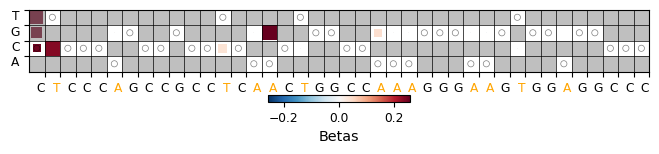

In [21]:
plot_millipede_heatmapV2('CD19_ABE8e_sigma_hit_table_everything.csv', 'presort_editing_freqs_avg_ABE8e_1_89_everything.csv' , 'wt_editing_freqs_avg_ABE8e_1_89_everything.csv')

In [14]:
millipede_dataframe_Betas_pivot, millipede_dataframe_PIPS_pivot, dfVariant = millipede_dataframe_cleanupV2('CD19_ABE8e_sigma_hit_table_everything.csv')
millipede_dataframe_Betas_pivot2, millipede_dataframe_PIPS_pivot2, dfVariant2 = millipede_dataframe_cleanupV2('CD19_evoCDA_sigma_hit_table_everything.csv')

dfVariantFinal = dfVariant + dfVariant2

# dfVariantFinal.head(40)

/tmp/ipykernel_218982/485529808.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  millipede_dataframe_Betas['MainIndex'] = millipede_dataframe_Betas['MainIndex'].astype(float)
/tmp/ipykernel_218982/485529808.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  millipede_dataframe_PIPS['MainIndex'] = millipede_dataframe['MainIndex'].astype(float)
/tmp/ipykernel_218982/485529808.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [15]:
import logomaker
import pandas as pd

# Your DNA sequence
sequence = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

# Create a DataFrame for one-hot encoding
one_hot_df = pd.DataFrame(0, index=range(len(sequence)), columns=['A', 'C', 'G', 'T'])

# Fill the DataFrame with one-hot encoding
for i, nucleotide in enumerate(sequence):
    one_hot_df.loc[i, nucleotide] = 0.25

one_hot_df

,A,C,G,T
0,0.25,0.00,0.00,0.00
1,0.00,0.25,0.00,0.00
2,0.25,0.00,0.00,0.00
3,0.00,0.00,0.00,0.25
4,0.00,0.00,0.25,0.00
...,...,...,...,...
341,0.00,0.00,0.25,0.00
342,0.25,0.00,0.00,0.00
343,0.00,0.00,0.25,0.00
344,0.00,0.00,0.00,0.25


In [9]:
SPIB = pd.read_csv('SPIB.txt', header = None, sep = ' ').dropna(axis=1)
SPIB.columns = ["A", "C", "G", "T"]
SPIB.index.name = "pos"
SPIB.to_csv('SPIBMain.txt', sep = '\t')




In [10]:
MYB = pd.read_csv('MYB_MA0100.3.txt', header = None, sep = ' ').dropna(axis=1)
MYB.columns = ["A", "C", "G", "T"]
MYB.index.name = "pos"
MYB.to_csv('MYBMain_MA0100.3.txt', sep = '\t')


In [11]:
def reverse_complement_pfm(pfm):
    # reverse complement sequence
    revcomp = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    pfm_rc = pfm.copy()
    pfm_rc = pfm_rc.iloc[::-1, ::-1].rename(columns=revcomp, index=revcomp)
    return pfm_rc

# create empty dataframe with all values set to 0
PWM1 = pd.DataFrame(data=np.zeros((40, 4)), index=range(0, 40), columns=['A', 'C', 'G', 'T'])
SPIB_RC = reverse_complement_pfm(SPIB)
PWM1.iloc[11:27, :] = SPIB_RC

PWM2 = pd.DataFrame(data=np.zeros((40, 4)), index=range(0, 40), columns=['A', 'C', 'G', 'T'])
IKZF1 = pd.read_csv("IKZF1.txt", sep = "\t", index_col = 0)
PWM2.iloc[11:21, :] = IKZF1

PWM3 = pd.DataFrame(data=np.zeros((40, 4)), index=range(0, 40), columns=['A', 'C', 'G', 'T'])
PAX5V2 = pd.read_csv("PAX5V2.txt", sep = "\t", index_col = 0)
PAX5V2_RC = reverse_complement_pfm(PAX5V2)
PWM3.iloc[21:40, :] = PAX5V2_RC


PWM4 = pd.DataFrame(data=np.zeros((40, 4)), index=range(0, 40), columns=['A', 'C', 'G', 'T'])
MYB = pd.read_csv("MYBMain_MA0100.3.txt", sep = "\t", index_col = 0)
PWM4.iloc[11:21, :] = MYB


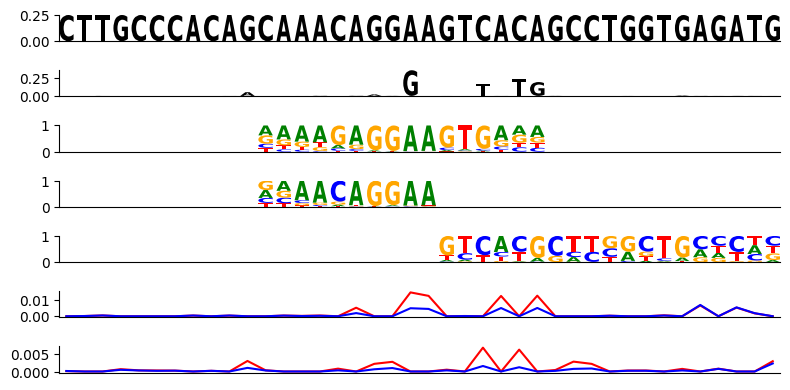

In [138]:
import matplotlib.pyplot as plt
import logomaker

dfVariantFinalPlot = dfVariantFinal.iloc[204:244,:]
one_hot_dfPlot = one_hot_df.iloc[204:244,:]

# Dimensions of the figure in inches
fig_width, fig_height = 8, 4  # Increase height to accommodate three plots
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(fig_width, fig_height), sharex=True)  

# Create the first sequence logo
seq_logo = logomaker.Logo(one_hot_dfPlot.reset_index(drop=True), ax=axes[0], color_scheme='black', width=0.8, center_values=False)
ars_logo = logomaker.Logo(dfVariantFinalPlot.reset_index(drop=True), ax=axes[1], color_scheme='black', width=0.8, center_values=False)
ars_logo1 = logomaker.Logo(PWM1, ax=axes[2], width=0.8, center_values=False)
ars_logo2 = logomaker.Logo(PWM2, ax=axes[3], width=0.8, center_values=False)
ars_logo3 = logomaker.Logo(PWM3, ax=axes[4], width=0.8, center_values=False)

enriched_editing_ABE = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/enriched_ABE8e_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])
baseline_editing_ABE = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/baseline_ABE8e_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])
enriched_editing_evoCDA = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/enriched_evoCDA_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])
baseline_editing_evoCDA = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/baseline_evoCDA_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])

editing_track = axes[5].plot(range(40), enriched_editing_ABE["editing"].iloc[204:244], color='red')
editing_track = axes[5].plot(range(40), baseline_editing_ABE["editing"].iloc[204:244], color='blue')
editing_track = axes[6].plot(range(40), enriched_editing_evoCDA["editing"].iloc[204:244], color='red')
editing_track = axes[6].plot(range(40), baseline_editing_evoCDA["editing"].iloc[204:244], color='blue')

# Remove spines and set x-ticks for each axis
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

fig.savefig('Figure2HeatmapBottom.svg', format='svg')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


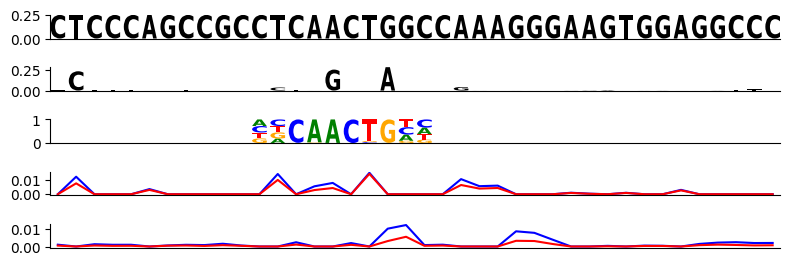

In [16]:
import matplotlib.pyplot as plt
import logomaker

dfVariantFinalPlot = dfVariantFinal.iloc[136:176,:]
one_hot_dfPlot = one_hot_df.iloc[136:176,:]

# Dimensions of the figure in inches
fig_width, fig_height = 8, 2.75  # Increase height to accommodate three plots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(fig_width, fig_height), sharex=True)  

# Create the first sequence logo
seq_logo = logomaker.Logo(one_hot_dfPlot.reset_index(drop=True), ax=axes[0], color_scheme='black', width=0.8, center_values=False)
ars_logo = logomaker.Logo(dfVariantFinalPlot.reset_index(drop=True), ax=axes[1], color_scheme='black', width=0.8, center_values=False)
ars_logo1 = logomaker.Logo(PWM4, ax=axes[2], width=0.8, center_values=False)

enriched_editing_ABE = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/enriched_ABE8e_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])
baseline_editing_ABE = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/baseline_ABE8e_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])
enriched_editing_evoCDA = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/enriched_evoCDA_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])
baseline_editing_evoCDA = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/baseline_evoCDA_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])

editing_track = axes[3].plot(range(40), enriched_editing_ABE["editing"].iloc[136:176], color='blue')
editing_track = axes[3].plot(range(40), baseline_editing_ABE["editing"].iloc[136:176], color='red')
editing_track = axes[4].plot(range(40), enriched_editing_evoCDA["editing"].iloc[136:176], color='blue')
editing_track = axes[4].plot(range(40), baseline_editing_evoCDA["editing"].iloc[136:176], color='red')

# Remove spines and set x-ticks for each axis
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

fig.savefig('SupplmentaryFigure2HeatmapBottom.svg', format='svg')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
